In [12]:
import numpy as np
import pandas as pd
from pandas import Series
from pandas_datareader import data

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA

from matplotlib import pyplot
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

### The tweets were previously downloaded using the comand: GetOldTweets3 --username "elonmusk" --output ./Homeworks/HW4/musc_all.csv
### We are using tweets from Elon Musc

In [13]:
# Load the dataset and filter leaving only 5 years

file = './musc_all.csv'
end_date = '2018-01-01'
start_date = '2013-01-01'

tweets = pd.read_csv(file)
tweets['date'] = pd.to_datetime(tweets['date'])

s_lower = tweets['date'] > start_date
s_higher = tweets['date'] < end_date
tweets = tweets[s_lower & s_higher]

In [14]:
def sentiment_score(text):
    analyzer = SentimentIntensityAnalyzer()
    a = analyzer.polarity_scores(text)
    return a['compound']

In [15]:
# Make the dataset with the time series
time_series = pd.DataFrame()
time_series['date'] = tweets['date']
time_series['senti_score'] = [sentiment_score(text) for text in tweets['text'] ]
time_series['day'] = [a.replace(hour=0, minute=0, second=0, microsecond=0) for a in time_series['date']]
time_series = time_series.drop(labels='date',axis=1)

# Agragate by day (average sentiment score in each day)
time_series = time_series.groupby('day').agg('mean')

### We are using the vaderSentiment library to compute the sentiment score. 
### It is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media, which makes it appropriate for our task
### If we observe multiple tweets in one day, we compute the average sentiment score of them

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


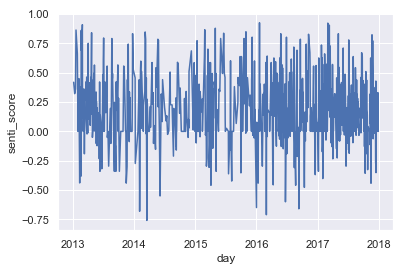

In [16]:
# Time series plot 

ds = time_series[:]
ax = sns.lineplot(x = ds.index, y="senti_score", data=ds)

In [17]:
# Descriptive statistics
print(time_series['senti_score'].describe())

count    798.000000
mean       0.194812
std        0.281482
min       -0.757900
25%        0.000000
50%        0.169327
75%        0.379212
max        0.924600
Name: senti_score, dtype: float64


In [51]:
# Augmented Dickey–Fuller test for stationarity 

series = time_series['senti_score']
X = series.values
result = adfuller(X)
print( 'P value = ',result[1])
if result[1]<0.05: 
    print('The data is stationary! ')
else:
    print('The data is NOT stationary')


P value =  4.273336810682234e-30
The data is stationary! 


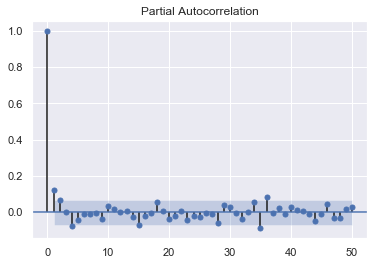

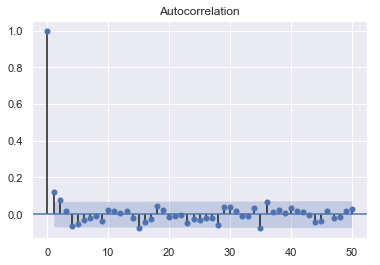

In [19]:
# Acf and Pacf plots 
series = time_series['senti_score']
plot_pacf(series, lags=50)
pyplot.show()

plot_acf(series, lags=50)
pyplot.show()

### Based on the plots the process appears to be ARMA(2,2) as both ACF and PACF display significant values for lags 1 and 2 followed by values close to 0
### The data seems to be stationary considering  both the time series plot and the Dickey–Fuller test

In [20]:
# Estimating the ARMA model

model = ARMA(time_series.senti_score, order=(2,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:            senti_score   No. Observations:                  798
Model:                     ARMA(2, 2)   Log Likelihood                -110.824
Method:                       css-mle   S.D. of innovations              0.278
Date:                Thu, 30 May 2019   AIC                            233.649
Time:                        23:34:45   BIC                            261.741
Sample:                             0   HQIC                           244.442
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1948      0.011     17.132      0.000       0.173       0.217
ar.L1.senti_score     0.7013      0.228      3.082      0.002       0.255       1.147
ar.L2.senti_score    -0.

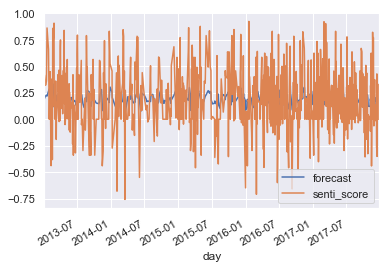

In [21]:
# Ploting the prediction 

model_fit.plot_predict(dynamic=False)
plt.show()

In [22]:
# S&P log returns 

SNP = data.DataReader("^GSPC", 'yahoo', start_date, end_date)

SNP['Log']=np.log(SNP['Adj Close'])
Returns=np.diff(SNP['Log'])*100
Returns=np.append(0,Returns)
SNP['Returns']=Returns

In [28]:
# Join SNP500 and twitter sentiment time series
time_series_snp = time_series.join(SNP,how='inner')

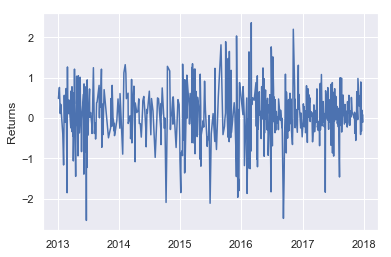

In [38]:
# Time series plots of SNP 500 

ds = time_series_snp[:]
ax = sns.lineplot(x = ds.index, y="Returns", data=ds)

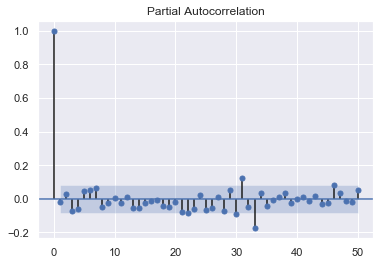

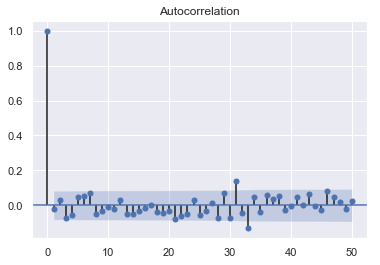

In [39]:
# Acf and Pacf plots of SNP 500 returns

series = time_series_snp['Returns']
plot_pacf(series, lags=50)
pyplot.show()

plot_acf(series, lags=50)
pyplot.show()

In [40]:
# Augmented Dickey–Fuller test for SNP 500 returns

series = time_series_snp['senti_score']
X = series.values
result = adfuller(X)
print( 'P value = ',result[1])
if result[1]<0.05: 
    print('The data is stationary! ')
else:
    print('The data is NOT stationary')

P value =  1.300345627426561e-29
The data is stationary! 


In [49]:
# Granger cousality test 

x = time_series_snp[['senti_score','Returns']].values
maxlag = 2

grangercausalitytests(x, maxlag, addconst=True, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1321  , p=0.1448  , df_denom=553, df_num=1
ssr based chi2 test:   chi2=2.1437  , p=0.1432  , df=1
likelihood ratio test: chi2=2.1396  , p=0.1435  , df=1
parameter F test:         F=2.1321  , p=0.1448  , df_denom=553, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3102  , p=0.2706  , df_denom=550, df_num=2
ssr based chi2 test:   chi2=2.6443  , p=0.2666  , df=2
likelihood ratio test: chi2=2.6380  , p=0.2674  , df=2
parameter F test:         F=1.3102  , p=0.2706  , df_denom=550, df_num=2


{1: ({'lrtest': (2.139593541700833, 0.14353991810608502, 1),
   'params_ftest': (2.132148797712288, 0.14480629486612118, 553.0, 1.0),
   'ssr_chi2test': (2.143715608549859, 0.14315479799283554, 1),
   'ssr_ftest': (2.13214879771236, 0.14480629486610638, 553.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (2.6379866496329214, 0.2674043558471979, 2),
   'params_ftest': (1.3102218621637407, 0.2706008283551603, 550.0, 2.0),
   'ssr_chi2test': (2.6442659400032396, 0.26656611762274307, 2),
   'ssr_ftest': (1.3102218621637673, 0.2706008283551603, 550.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])])}

In [50]:
# Granger cousality test 

x = time_series_snp[['Returns','senti_score']].values
maxlag = 2

grangercausalitytests(x, maxlag, addconst=True, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5649  , p=0.2115  , df_denom=553, df_num=1
ssr based chi2 test:   chi2=1.5734  , p=0.2097  , df=1
likelihood ratio test: chi2=1.5712  , p=0.2100  , df=1
parameter F test:         F=1.5649  , p=0.2115  , df_denom=553, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8868  , p=0.4125  , df_denom=550, df_num=2
ssr based chi2 test:   chi2=1.7898  , p=0.4086  , df=2
likelihood ratio test: chi2=1.7869  , p=0.4092  , df=2
parameter F test:         F=0.8868  , p=0.4125  , df_denom=550, df_num=2


{1: ({'lrtest': (1.5711725958458373, 0.21003680606784964, 1),
   'params_ftest': (1.5649050980284596, 0.21147744965990511, 553.0, 1.0),
   'ssr_chi2test': (1.5733946374391843, 0.20971471414518295, 1),
   'ssr_ftest': (1.564905098028541, 0.2114774496598946, 553.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (1.786930123426373, 0.4092352676816723, 2),
   'params_ftest': (0.8868427418973239, 0.41254259129117765, 550.0, 2.0),
   'ssr_chi2test': (1.7898098972835876, 0.4086464391939669, 2),
   'ssr_ftest': (0.8868427418972732, 0.4125425912911903, 550.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])])}

### We made a test for causality up to 2 lags. The P-values are bigger than 0.05 which means that the null hypothesis can not be rejected and sentiment scores of tweents do not granger cause the S&P returns. We observe similar situation when running the test in the oposite direction - the S&P returns do not seem to cause the sentiment polarity of tweets 